# Measure the 2-point correlation function using DES deep fields data:

* Download the DES galaxy catalog ( we choose here one of the SN fields bc there are 3 supernovae fields and 1 COSMOS)
* Create a random catalog of galaxies with the same density as the real catalog.
* Calculate the number of pairs of galaxies within a given angular separation for both the real and random catalogs.
* Divide the number of real pairs by the number of random pairs to obtain the 2-point correlation function.


In [22]:
import astropy.io.fits as fits
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import treecorr

# Get the current user's home directory
home_dir = os.path.expanduser('~')

# Construct the path to the "Thesis" directory on the desktop
thesis_path = os.path.join(home_dir, 'Desktop', 'Thesis')


# Assuming you have the path to the FITS file stored in thesis_path
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  # Replace with your actual file name


In [23]:
t= Table.read(fits_file_path)
t  



id,ra,dec,fof_id,fof_size,mask_flags,flags,flagstr,badpix_frac,psf_g_0,psf_g_1,psf_T,bdf_T,bdf_T_err,bdf_T_ratio,bdf_g_0,bdf_g_1,bdf_fracdev,bdf_fracdev_err,tilename,EBV_SFD98,mask_flags_nir,flags_nir,flagstr_nir,badpix_frac_nir,psf_flux_u,psf_flux_g,psf_flux_r,psf_flux_i,psf_flux_z,psf_flux_J,psf_flux_H,psf_flux_Ks,psf_flux_err_u,psf_flux_err_g,psf_flux_err_r,psf_flux_err_i,psf_flux_err_z,psf_flux_err_J,psf_flux_err_H,psf_flux_err_Ks,bdf_flux_u,bdf_flux_g,bdf_flux_r,bdf_flux_i,bdf_flux_z,bdf_flux_J,bdf_flux_H,bdf_flux_Ks,bdf_flux_err_u,bdf_flux_err_g,bdf_flux_err_r,bdf_flux_err_i,bdf_flux_err_z,bdf_flux_err_J,bdf_flux_err_H,bdf_flux_err_Ks,gap_flux_u,gap_flux_g,gap_flux_r,gap_flux_i,gap_flux_z,gap_flux_J,gap_flux_H,gap_flux_Ks,gap_flux_err_u,gap_flux_err_g,gap_flux_err_r,gap_flux_err_i,gap_flux_err_z,gap_flux_err_J,gap_flux_err_H,gap_flux_err_Ks,psf_flux_calib_u,psf_flux_calib_g,psf_flux_calib_r,psf_flux_calib_i,psf_flux_calib_z,psf_flux_calib_J,psf_flux_calib_H,psf_flux_calib_Ks,psf_flux_err_calib_u,psf_flux_err_calib_g,psf_flux_err_calib_r,psf_flux_err_calib_i,psf_flux_err_calib_z,psf_flux_err_calib_J,psf_flux_err_calib_H,psf_flux_err_calib_Ks,bdf_flux_calib_u,bdf_flux_calib_g,bdf_flux_calib_r,bdf_flux_calib_i,bdf_flux_calib_z,bdf_flux_calib_J,bdf_flux_calib_H,bdf_flux_calib_Ks,bdf_flux_err_calib_u,bdf_flux_err_calib_g,bdf_flux_err_calib_r,bdf_flux_err_calib_i,bdf_flux_err_calib_z,bdf_flux_err_calib_J,bdf_flux_err_calib_H,bdf_flux_err_calib_Ks,psf_flux_dered_u,psf_flux_dered_g,psf_flux_dered_r,psf_flux_dered_i,psf_flux_dered_z,psf_flux_dered_J,psf_flux_dered_H,psf_flux_dered_Ks,psf_flux_err_dered_u,psf_flux_err_dered_g,psf_flux_err_dered_r,psf_flux_err_dered_i,psf_flux_err_dered_z,psf_flux_err_dered_J,psf_flux_err_dered_H,psf_flux_err_dered_Ks,bdf_flux_dered_u,bdf_flux_dered_g,bdf_flux_dered_r,bdf_flux_dered_i,bdf_flux_dered_z,bdf_flux_dered_J,bdf_flux_dered_H,bdf_flux_dered_Ks,bdf_flux_err_dered_u,bdf_flux_err_dered_g,bdf_flux_err_dered_r,bdf_flux_err_dered_i,bdf_flux_err_dered_z,bdf_flux_err_dered_J,bdf_flux_err_dered_H,bdf_flux_err_dered_Ks,psf_flux_dered_calib_u,psf_flux_dered_calib_g,psf_flux_dered_calib_r,psf_flux_dered_calib_i,psf_flux_dered_calib_z,psf_flux_dered_calib_J,psf_flux_dered_calib_H,psf_flux_dered_calib_Ks,psf_flux_err_dered_calib_u,psf_flux_err_dered_calib_g,psf_flux_err_dered_calib_r,psf_flux_err_dered_calib_i,psf_flux_err_dered_calib_z,psf_flux_err_dered_calib_J,psf_flux_err_dered_calib_H,psf_flux_err_dered_calib_Ks,bdf_flux_dered_calib_u,bdf_flux_dered_calib_g,bdf_flux_dered_calib_r,bdf_flux_dered_calib_i,bdf_flux_dered_calib_z,bdf_flux_dered_calib_J,bdf_flux_dered_calib_H,bdf_flux_dered_calib_Ks,bdf_flux_err_dered_calib_u,bdf_flux_err_dered_calib_g,bdf_flux_err_dered_calib_r,bdf_flux_err_dered_calib_i,bdf_flux_err_dered_calib_z,bdf_flux_err_dered_calib_J,bdf_flux_err_dered_calib_H,bdf_flux_err_dered_calib_Ks,psf_mag_u,psf_mag_g,psf_mag_r,psf_mag_i,psf_mag_z,psf_mag_J,psf_mag_H,psf_mag_Ks,psf_mag_dered_u,psf_mag_dered_g,psf_mag_dered_r,psf_mag_dered_i,psf_mag_dered_z,psf_mag_dered_J,psf_mag_dered_H,psf_mag_dered_Ks,psf_mag_err_dered_u,psf_mag_err_dered_g,psf_mag_err_dered_r,psf_mag_err_dered_i,psf_mag_err_dered_z,psf_mag_err_dered_J,psf_mag_err_dered_H,psf_mag_err_dered_Ks,psf_mag_dered_calib_u,psf_mag_dered_calib_g,psf_mag_dered_calib_r,psf_mag_dered_calib_i,psf_mag_dered_calib_z,psf_mag_dered_calib_J,psf_mag_dered_calib_H,psf_mag_dered_calib_Ks,bdf_mag_u,bdf_mag_g,bdf_mag_r,bdf_mag_i,bdf_mag_z,bdf_mag_J,bdf_mag_H,bdf_mag_Ks,bdf_mag_dered_u,bdf_mag_dered_g,bdf_mag_dered_r,bdf_mag_dered_i,bdf_mag_dered_z,bdf_mag_dered_J,bdf_mag_dered_H,bdf_mag_dered_Ks,bdf_mag_err_dered_u,bdf_mag_err_dered_g,bdf_mag_err_dered_r,bdf_mag_err_dered_i,bdf_mag_err_dered_z,bdf_mag_err_dered_J,bdf_mag_err_dered_H,bdf_mag_err_dered_Ks,bdf_mag_dered_calib_u,bdf_mag_dered_calib_g,bdf_mag_dered_calib_r,bdf_mag_dered_calib_i,bdf_mag_dered_calib_z,bdf_mag_dered_calib_J,bdf_mag_dered_calib_H,bdf_mag_dered_calib_Ks,kNN_class,z,SM
in

In [24]:
masked = os.path.join(thesis_path, "SN-C3_masked_cat.fits")  # Replace with your actual file name

t3= Table.read(masked)
t3

id,ra,dec,fof_id,fof_size,mask_flags,flags,flagstr,badpix_frac,psf_g_0,psf_g_1,psf_T,bdf_T,bdf_T_err,bdf_T_ratio,bdf_g_0,bdf_g_1,bdf_fracdev,bdf_fracdev_err,tilename,EBV_SFD98,mask_flags_nir,flags_nir,flagstr_nir,badpix_frac_nir,psf_flux_u,psf_flux_g,psf_flux_r,psf_flux_i,psf_flux_z,psf_flux_J,psf_flux_H,psf_flux_Ks,psf_flux_err_u,psf_flux_err_g,psf_flux_err_r,psf_flux_err_i,psf_flux_err_z,psf_flux_err_J,psf_flux_err_H,psf_flux_err_Ks,bdf_flux_u,bdf_flux_g,bdf_flux_r,bdf_flux_i,bdf_flux_z,bdf_flux_J,bdf_flux_H,bdf_flux_Ks,bdf_flux_err_u,bdf_flux_err_g,bdf_flux_err_r,bdf_flux_err_i,bdf_flux_err_z,bdf_flux_err_J,bdf_flux_err_H,bdf_flux_err_Ks,gap_flux_u,gap_flux_g,gap_flux_r,gap_flux_i,gap_flux_z,gap_flux_J,gap_flux_H,gap_flux_Ks,gap_flux_err_u,gap_flux_err_g,gap_flux_err_r,gap_flux_err_i,gap_flux_err_z,gap_flux_err_J,gap_flux_err_H,gap_flux_err_Ks,psf_flux_calib_u,psf_flux_calib_g,psf_flux_calib_r,psf_flux_calib_i,psf_flux_calib_z,psf_flux_calib_J,psf_flux_calib_H,psf_flux_calib_Ks,psf_flux_err_calib_u,psf_flux_err_calib_g,psf_flux_err_calib_r,psf_flux_err_calib_i,psf_flux_err_calib_z,psf_flux_err_calib_J,psf_flux_err_calib_H,psf_flux_err_calib_Ks,bdf_flux_calib_u,bdf_flux_calib_g,bdf_flux_calib_r,bdf_flux_calib_i,bdf_flux_calib_z,bdf_flux_calib_J,bdf_flux_calib_H,bdf_flux_calib_Ks,bdf_flux_err_calib_u,bdf_flux_err_calib_g,bdf_flux_err_calib_r,bdf_flux_err_calib_i,bdf_flux_err_calib_z,bdf_flux_err_calib_J,bdf_flux_err_calib_H,bdf_flux_err_calib_Ks,psf_flux_dered_u,psf_flux_dered_g,psf_flux_dered_r,psf_flux_dered_i,psf_flux_dered_z,psf_flux_dered_J,psf_flux_dered_H,psf_flux_dered_Ks,psf_flux_err_dered_u,psf_flux_err_dered_g,psf_flux_err_dered_r,psf_flux_err_dered_i,psf_flux_err_dered_z,psf_flux_err_dered_J,psf_flux_err_dered_H,psf_flux_err_dered_Ks,bdf_flux_dered_u,bdf_flux_dered_g,bdf_flux_dered_r,bdf_flux_dered_i,bdf_flux_dered_z,bdf_flux_dered_J,bdf_flux_dered_H,bdf_flux_dered_Ks,bdf_flux_err_dered_u,bdf_flux_err_dered_g,bdf_flux_err_dered_r,bdf_flux_err_dered_i,bdf_flux_err_dered_z,bdf_flux_err_dered_J,bdf_flux_err_dered_H,bdf_flux_err_dered_Ks,psf_flux_dered_calib_u,psf_flux_dered_calib_g,psf_flux_dered_calib_r,psf_flux_dered_calib_i,psf_flux_dered_calib_z,psf_flux_dered_calib_J,psf_flux_dered_calib_H,psf_flux_dered_calib_Ks,psf_flux_err_dered_calib_u,psf_flux_err_dered_calib_g,psf_flux_err_dered_calib_r,psf_flux_err_dered_calib_i,psf_flux_err_dered_calib_z,psf_flux_err_dered_calib_J,psf_flux_err_dered_calib_H,psf_flux_err_dered_calib_Ks,bdf_flux_dered_calib_u,bdf_flux_dered_calib_g,bdf_flux_dered_calib_r,bdf_flux_dered_calib_i,bdf_flux_dered_calib_z,bdf_flux_dered_calib_J,bdf_flux_dered_calib_H,bdf_flux_dered_calib_Ks,bdf_flux_err_dered_calib_u,bdf_flux_err_dered_calib_g,bdf_flux_err_dered_calib_r,bdf_flux_err_dered_calib_i,bdf_flux_err_dered_calib_z,bdf_flux_err_dered_calib_J,bdf_flux_err_dered_calib_H,bdf_flux_err_dered_calib_Ks,psf_mag_u,psf_mag_g,psf_mag_r,psf_mag_i,psf_mag_z,psf_mag_J,psf_mag_H,psf_mag_Ks,psf_mag_dered_u,psf_mag_dered_g,psf_mag_dered_r,psf_mag_dered_i,psf_mag_dered_z,psf_mag_dered_J,psf_mag_dered_H,psf_mag_dered_Ks,psf_mag_err_dered_u,psf_mag_err_dered_g,psf_mag_err_dered_r,psf_mag_err_dered_i,psf_mag_err_dered_z,psf_mag_err_dered_J,psf_mag_err_dered_H,psf_mag_err_dered_Ks,psf_mag_dered_calib_u,psf_mag_dered_calib_g,psf_mag_dered_calib_r,psf_mag_dered_calib_i,psf_mag_dered_calib_z,psf_mag_dered_calib_J,psf_mag_dered_calib_H,psf_mag_dered_calib_Ks,bdf_mag_u,bdf_mag_g,bdf_mag_r,bdf_mag_i,bdf_mag_z,bdf_mag_J,bdf_mag_H,bdf_mag_Ks,bdf_mag_dered_u,bdf_mag_dered_g,bdf_mag_dered_r,bdf_mag_dered_i,bdf_mag_dered_z,bdf_mag_dered_J,bdf_mag_dered_H,bdf_mag_dered_Ks,bdf_mag_err_dered_u,bdf_mag_err_dered_g,bdf_mag_err_dered_r,bdf_mag_err_dered_i,bdf_mag_err_dered_z,bdf_mag_err_dered_J,bdf_mag_err_dered_H,bdf_mag_err_dered_Ks,bdf_mag_dered_calib_u,bdf_mag_dered_calib_g,bdf_mag_dered_calib_r,bdf_mag_dered_calib_i,bdf_mag_dered_calib_z,bdf_mag_dered_calib_J,bdf_mag_dered_calib_H,bdf_mag_dered_calib_Ks,kNN_class
int64,f

In [25]:
t=join(t,t3,keys='id')


t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')

In [26]:

# Access the columns directly
redshift = t['z']  # Access the 'z' column for redshift
declination = t['dec']  # Access the 'dec' column for declination
right_ascension = t['ra']  # Access the 'ra' column for right ascension

# Optional: explore or analyze the data
print(redshift.shape)  # Check the shape of the redshift array
print(f"Minimum redshift: {redshift.min()}")
print(f"Maximum redshift: {redshift.max()}")



(415091,)
Minimum redshift: 0.037304999999999984
Maximum redshift: 4.613163999999999


In [27]:
# Select redshift subset 
subset = (t['z'] > 0.6) & (t['z'] < 0.7) & (t['SM']>10.5)& (t['SM']<11) #solar masses

# Extract right ascension (ra) and declination (dec) arrays from the subset
ra_subset = t['ra'][subset] #[::100]
dec_subset = t['dec'][subset]#[::100]

catalog=SkyCoord(ra=ra_subset*u.deg, dec=dec_subset*u.deg)

N = len(catalog)



#def calculate_separations(cat, N):
    #"""Calculates the angular separation between all pairs of objects in a catalog.

    #Args:
       # catalog1: An astropy.coordinates.SkyCoord object containing object coordinates.
       # N: The number of bins for the separation histogram.

   # Returns:
      #  A numpy array of size N containing the counts of objects in each separation bin.
   # """

    #separation = cat.separation(cat[:, np.newaxis])

    #return separation

In [28]:
def count_pairs_in_theta_bin(cat,theta_edges):
    """Counts the number of pairs of objects in a catalog that have an angular separation
    within a specified theta bin.

    Args:
        catalog: An astropy.coordinates.SkyCoord object containing object coordinates.
        theta_bins: A tuple defining the angular separation bin.

    Returns:
        The number of pairs within the theta bin.
    """
    separation = cat.separation(cat[:, np.newaxis]) #Calculates the angular separation between all pairs of objects in a catalog.
    theta_hist,_= np.histogram(np.log10(separation.value),bins=theta_edges)

    #for i in range(0,N):
        #for j in range(i, N):
            #theta = calculate_separations(catalog[i],catalog[j])
            #theta_bins = calculate_separations(theta)
            
            #separation = catalog[i].separation(catalog[j]).to('deg').value
            #theta_bins = calculate_separations(SkyCoord(ra=ra_subset * u.deg, dec=dec_subset * u.deg), N=50)

            #theta_bins += 1

    return theta_hist


theta_edges=np.linspace(-2.5,0.25,50) #-2.5 and 0.25 are log of the max and min separation in degrees
dd_counts=count_pairs_in_theta_bin(catalog,theta_edges)  
print(dd_counts)

[   28    12    22    20    24    34    38    34    50    66   102   134
   152   172   236   248   360   420   508   588   748   948  1216  1502
  1848  2268  2958  3692  4342  5772  7554  9648 11864 14196 17522 21088
 26476 31398 37736 44654 53178 62694 72880 83102 88720 87172 73284 54380
 28074]


/var/folders/sm/7ys1bjcx13x_c71jgspgdldh0000gn/T/ipykernel_10263/974065978.py:13: RuntimeWarning: divide by zero encountered in log10
  theta_hist,_= np.histogram(np.log10(separation.value),bins=theta_edges)


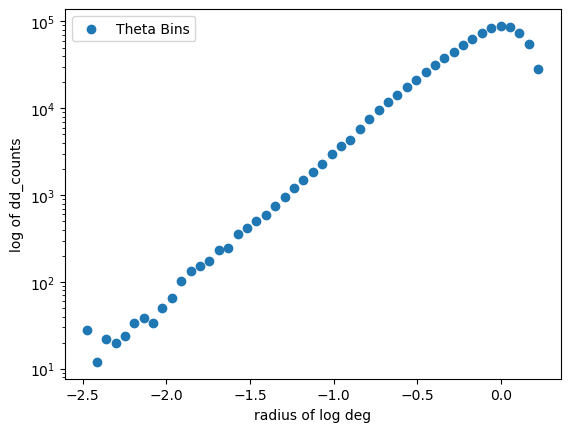

In [29]:
theta_edges=np.linspace(-2.5,0.25,50)

# bin centers
theta_cen= (theta_edges[:-1]+theta_edges[1:])/2

# Plot the theta bins
plt.scatter(theta_cen, dd_counts, label='Theta Bins')
plt.yscale('log')

# Set labels and title
plt.xlabel('radius of log deg')
plt.ylabel('log of dd_counts')
plt.title('')

# Show the plot
plt.legend()
plt.show()

## Catalog for randoms

In [30]:
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 

# Open the FITS file using astropy.io.fits
hdulist = fits.open(fits_random)
hdulist.info()

t2= Table.read(fits_random)
t2

Filename: /Users/otilia/Desktop/Thesis/SN-C3_randoms_ugriz_trim_video.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  SN-C3_C01_randoms_raw.fits    1 BinTableHDU     18   13402307R x 3C   [E, E, 9A]   


ra,dec,Tilename
float32,float32,bytes9
52.4174,-27.207537,SN-C3_C01
52.449112,-27.199625,SN-C3_C01
52.263237,-27.225185,SN-C3_C01
52.363953,-27.128168,SN-C3_C01
52.19789,-27.176682,SN-C3_C01
52.369183,-27.188385,SN-C3_C01
...,...,...
53.090096,-29.023394,SN-C3_C62
53.002266,-28.988358,SN-C3_C62


In [31]:
# Extract right ascension (ra) and declination (dec) arrays from the subset
ra_2 = t2['ra'][::1000]
dec_2 = t2['dec'][::1000]




In [32]:
random_catalog=SkyCoord(ra=ra_2*u.deg, dec=dec_2*u.deg)



In [33]:
def calculate_2pcf(catalog, random_catalog, theta_edges):
    """Calculates the two-point correlation function (2PCF).

    Args:
        catalog: An astropy.coordinates.SkyCoord object containing data points.
        random_catalog: An astropy.coordinates.SkyCoord object containing random points.
        theta_cen: A numpy array defining the angular separation bin edges.

    Returns:
        A numpy array containing the 2PCF values for each theta bin.
    """

    # Calculate DD counts
    dd_counts = count_pairs_in_theta_bin(catalog, theta_edges)

    # Calculate RR counts
    rr_counts = count_pairs_in_theta_bin(random_catalog, theta_edges)
    
    
    #Normalise
    norma_dd= dd_counts/np.sum(dd_counts) 
    norma_rr= rr_counts/np.sum(rr_counts) 


    # Calculate 2PCF
    two_pcf = (norma_dd / norma_rr) - 1 # w_measured

    return two_pcf


theta_cen= (theta_edges[:-1]+theta_edges[1:])/2

two_pcf_result = calculate_2pcf(catalog, random_catalog, theta_edges)

print(two_pcf_result)



/var/folders/sm/7ys1bjcx13x_c71jgspgdldh0000gn/T/ipykernel_10263/974065978.py:13: RuntimeWarning: divide by zero encountered in log10
  theta_hist,_= np.histogram(np.log10(separation.value),bins=theta_edges)


[ 4.34318251  0.69958568  1.49340229  0.68904348  0.72296375  0.76392553
  0.61340236  0.13933167  0.26051065  0.35829466  0.69566085  0.70514529
  0.55436677  0.36786077  0.52115603  0.25946074  0.44441264  0.32211923
  0.26312232  0.150602    0.15319764  0.15114122  0.16626245  0.13383351
  0.10490665  0.076893    0.11240659  0.10685071  0.04051824  0.10491505
  0.1144931   0.1020051   0.09986214  0.07067571  0.08472521  0.06841488
  0.08075606  0.06480137  0.08049011  0.05075073  0.03620803  0.0140921
 -0.00713994 -0.01831074 -0.03503002 -0.0311621  -0.08349272 -0.08065542
 -0.05306455]


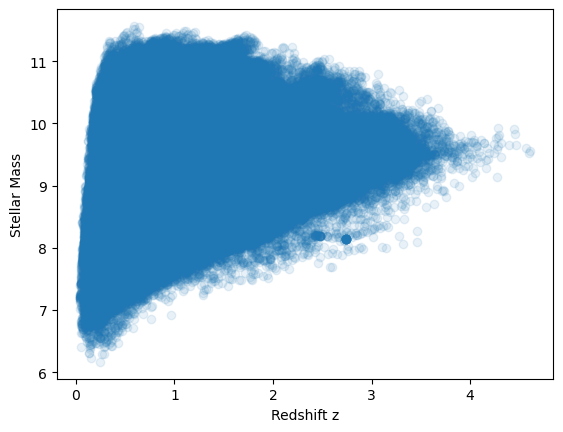

In [34]:
plt.scatter(t['z'],t['SM'],alpha=0.1)
plt.xlabel('Redshift z')
plt.ylabel('Stellar Mass')
plt.show()

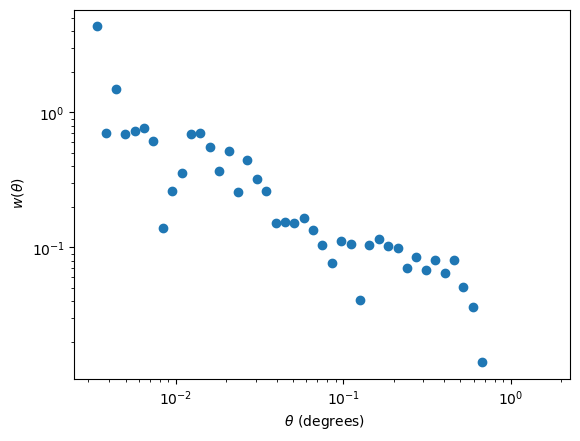

In [35]:
deg_theta_cen=10**theta_cen

plt.scatter(deg_theta_cen, two_pcf_result)
plt.yscale('log')
plt.xscale('log')

# Set labels and title
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')

# Show the plot
plt.show()

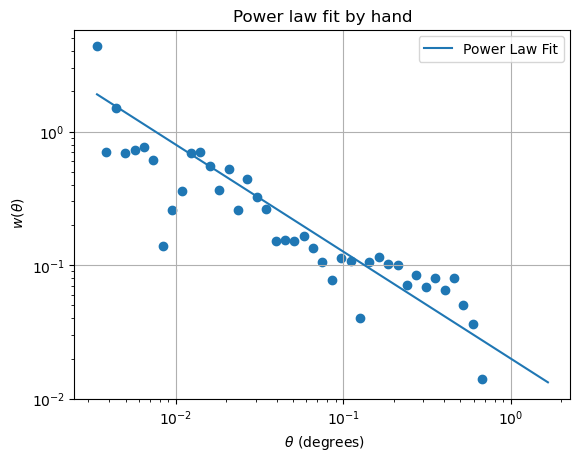

In [36]:
deg_theta_cen=10**theta_cen
A=2*1e-2  #amplitude, best is 2*1e-2 aka 0.02
w_fit= A*deg_theta_cen**(-0.8) #w(theta)

plt.scatter(deg_theta_cen, two_pcf_result)
plt.plot(deg_theta_cen, w_fit, label='Power Law Fit')
plt.yscale('log')
plt.xscale('log')

# Set labels and title
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.title("Power law fit by hand")

# Show the plot
plt.grid(True)
plt.legend()
plt.show()

#### Note: cut first point for better fit

Power-law fit parameters:
  r0: 272.6017931625111
  gamma: -0.6353456881294082


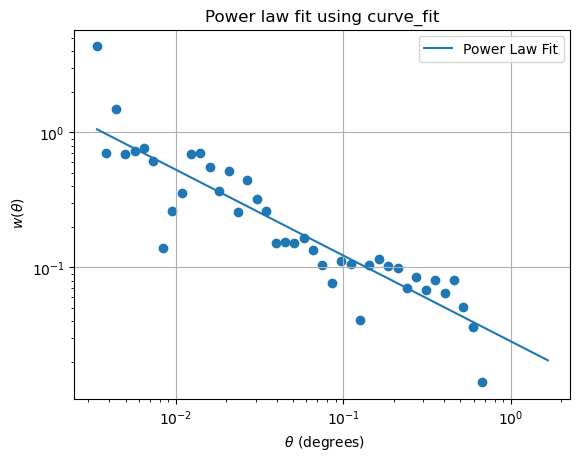

In [37]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

# Define the Peebles & Groth (1975) power law function
def power_law(x, r0, gamma):
    return (x *r0)**gamma

# Fit the power law
popt, pcov = curve_fit(power_law, deg_theta_cen[1:], two_pcf_result[1:], p0=[2*1e-2, -0.8])  # Initial guesses 

# Print fit parameters
print("Power-law fit parameters:")
print("  r0:", popt[0])
print("  gamma:", popt[1])

# Create the plot (log scale for y-axis)
plt.scatter(deg_theta_cen, two_pcf_result)
plt.plot(deg_theta_cen, power_law(deg_theta_cen, *popt), label='Power Law Fit')

# Set labels and title
# Set labels and title
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.title("Power law fit using curve_fit")
plt.yscale('log')
plt.xscale('log')

# Show the plot
plt.grid(True)
plt.legend()
plt.show()

## Integral constraint
#### Due to the relatively small volume probed by the survey, the integral constraint affects w(θ) at large scales.

We adjust the model to take this into account. The correction factor due to the IC can be estimated from the double integration of the true correlation function over the survey area. This integration can be carried out using the random-random pairs from the random catalog following Roche & Eales (1999) where wtrue(θ) is HOD-predicted model. Finally, the model that we fit against the data is simply w(θ) = wtrue(θ) − wIC.


In [38]:
# Calculate DD counts
dd_counts = count_pairs_in_theta_bin(catalog, theta_edges)

# Calculate RR counts
rr_counts = count_pairs_in_theta_bin(random_catalog, theta_edges)
    
#Normalise
norma_dd= dd_counts/np.sum(dd_counts) 
norma_rr= rr_counts/np.sum(rr_counts) 

# Calculate 2PCF aka w(theta)= DD/RR - 1 
two_pcf = (norma_dd / norma_rr) - 1

w_IC = np.sum(w_fit * rr_counts / np.sum(rr_counts)) #IC = w_fit * RR(theta) / SUM(RR)

#ideally we want to use the w_true in the IC but we can't know it so we use w_fit

# w_measured is DD/RR- 1

w= two_pcf + np.sum(w_IC) # w_measured + w_IC 


/var/folders/sm/7ys1bjcx13x_c71jgspgdldh0000gn/T/ipykernel_10263/974065978.py:13: RuntimeWarning: divide by zero encountered in log10
  theta_hist,_= np.histogram(np.log10(separation.value),bins=theta_edges)


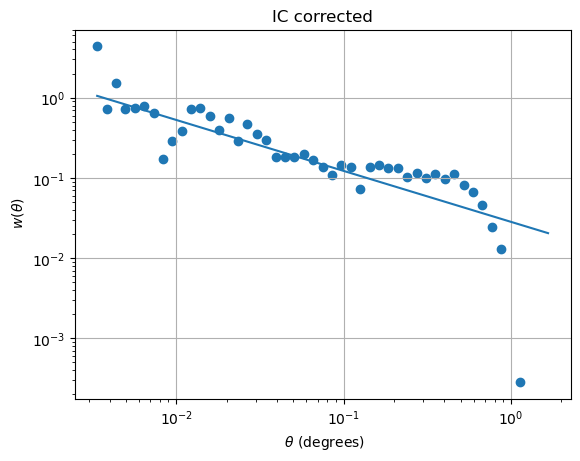

In [39]:
plt.scatter(deg_theta_cen, w)
plt.plot(deg_theta_cen, power_law(deg_theta_cen, *popt), label='Power Law Fit')
plt.yscale('log')
plt.xscale('log')

# Set labels and title
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.title("IC corrected")

# Show the plot
plt.grid(True)
plt.show()


## Implementing Gaussian Approximation for Errorbars

The Gaussian approximation to Poisson errors assumes that, for large counts, the Poisson distribution can be approximated by a normal distribution with mean and variance equal to the Poisson parameter 1  (in this case, the number of pairs). This approximation is reasonable when the number of pairs is sufficiently large.

In the Gaussian approximation, the fractional error is 1/sqrt(N pairs). We'll treat the RR part as being noiseless, and all the error as coming from Poisson error on the counting of DD pairs. So the errorbar on the ratio DD/RR is, ( 1 / sqrt(number of  DD pairs) ) * DD/RR

Power-law fit parameters:
  r0: 272.6017931625111
  gamma: -0.6353456881294082


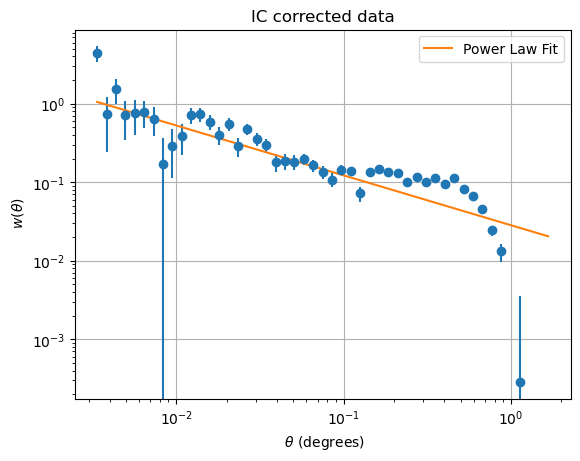

In [40]:

    
fractional_error = 1 / np.sqrt(dd_counts)
errorbars = fractional_error * (norma_dd / norma_rr)  #So the errorbar on the ratio DD/RR is: ( 1 / sqrt(number of  DD pairs) ) * DD/RR

plt.errorbar(deg_theta_cen, w, yerr=errorbars, fmt='o')
plt.plot(deg_theta_cen, power_law(deg_theta_cen, *popt), label='Power Law Fit')

plt.yscale('log')
plt.xscale('log')

# Print fit parameters
print("Power-law fit parameters:")
print("  r0:", popt[0])
print("  gamma:", popt[1])

# Set labels and title
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.title("IC corrected data")

# Show the plot
plt.grid(True)
plt.legend()
plt.show()

In [41]:
print(errorbars)

[1.00976658 0.49062812 0.53159516 0.3776816  0.3516985  0.30251073
 0.26172842 0.19539377 0.17826313 0.16719452 0.16789544 0.14730212
 0.12607579 0.10429841 0.09901882 0.07997584 0.07612723 0.06451281
 0.05604199 0.04745003 0.04216508 0.03738733 0.03344487 0.02925596
 0.02570245 0.02261263 0.02045335 0.01821622 0.01579082 0.01454339
 0.01282298 0.01121928 0.01009771 0.00898618 0.0081946  0.00735736
 0.00664204 0.00600921 0.00556215 0.00497244 0.00449346 0.00405009
 0.00367776 0.0034054  0.00323969 0.00328143 0.00338557 0.00394238
 0.00565156]


#### See that despite the fact that the number of DD pairs is very high at large separations, the error on DD/RR - 1 is quite large. At small separations, the fact that there are few DD pairs leads to large errors too.

## Use PyMC and implement IC

In [42]:
import pymc as pm
import arviz as az



In [75]:
w_fit= 2e-2* deg_theta_cen**(-0.8)
cuts=(deg_theta_cen>3e-3) & (deg_theta_cen <1) #define valid values
X= deg_theta_cen[cuts]
Y= w_fit[cuts]
Y_err = errorbars[cuts]
mask_rr= rr_counts[cuts]


# Build the PyMC model
with pm.Model() as model:
    # put our RR pair counts in tensor form    
    rr = pm.ConstantData("rr", mask_rr, dims="observation")

    # Define priors
    power= pm.Normal("power", mu= -0.8, sigma=10)
    A = pm.Normal("A", mu=2e-2, sigma=10)
    
    Y_pred = A * (X** power)
    IC = pm.math.sum(A * (X** power) * rr / pm.math.sum(rr))
    
    total_sigma=np.sqrt(Y_err**2)
    
    # Define likelihood
    likelihood = pm.Normal("Y", mu=Y_pred-IC, sigma=total_sigma, observed=Y, dims="observation")

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = pm.sample(3000)

#Extract posterior samples
power_post_parent= np.array(idata.posterior['power']).flatten()
A_post_parent = np.array(idata.posterior['A']).flatten()
    
power_median = np.median(power_post_parent)
A_median = np.median(A_post_parent)

print('power_median',power_median)
print('A_median', A_median)


/Users/otilia/anaconda3/lib/python3.11/site-packages/pymc/data.py:274: FutureWarning: ConstantData is deprecated. All Data variables are now mutable. Use Data instead.
  warnings.warn(
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [power, A]


Output()

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 4 seconds.
There were 89 divergences after tuning. Increase `target_accept` or reparameterize.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


power_median -0.7966546519539097
A_median 0.01704665917752067


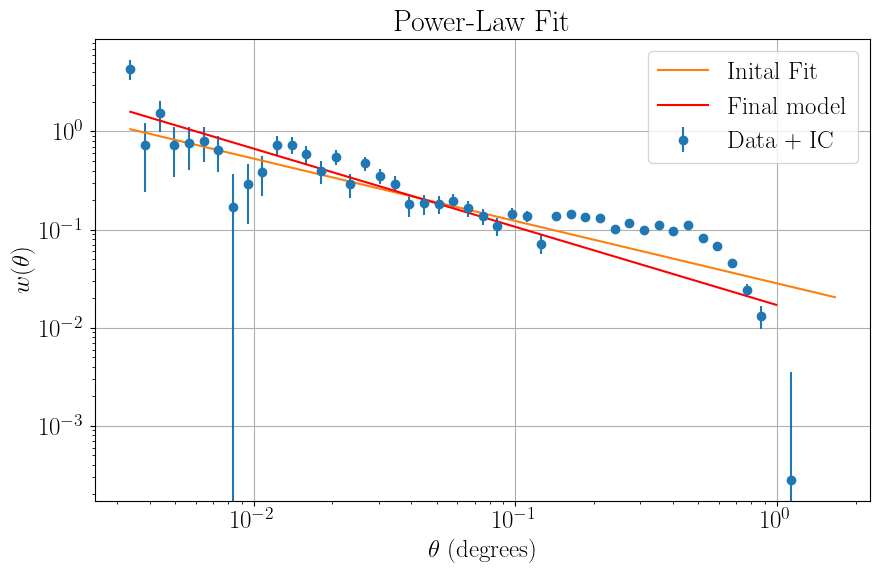

In [76]:

# Plot the data and fitted function
plt.figure(figsize=(10, 6))

plt.errorbar(deg_theta_cen, w, yerr=errorbars, fmt='o',label="Data + IC ") # w is data + IC
plt.plot(deg_theta_cen, power_law(deg_theta_cen, *popt), label='Inital Fit')

plt.plot(X, A_median * X**power_median, label="Final model", color="red")
plt.xlabel(r' $ \theta$ (degrees)')
plt.ylabel(r' $w(\theta)$')
plt.legend()
plt.yscale('log')
plt.xscale('log')
plt.title("Power-Law Fit")
plt.grid(True)

plt.show()





In [77]:
from astropy.cosmology import Planck15
import matplotlib.pyplot as plt
%matplotlib inline
plt.rc('font',**{'family':'serif','size':18})
plt.rc('text', usetex=True) # comment out this line if you don't have latex installed


z_mean = 0.65


def w_th(A, power, theta, rr):
    IC = pm.math.sum(A * (theta** power) * rr / pm.math.sum(rr))
    print(IC)

    return A * (theta**power) - IC #model - IC

print(np. array(w_th(A_median, power_median, X, mask_rr)) )


Sum{axes=None}.0
Sub.0


In [78]:
def w_t(A, power, theta, rr):
    IC = np.sum(A * (theta** power) * rr / np.sum(rr))
    print(IC)

    return A * (theta**power) - IC #model - IC


0.03231464976015835


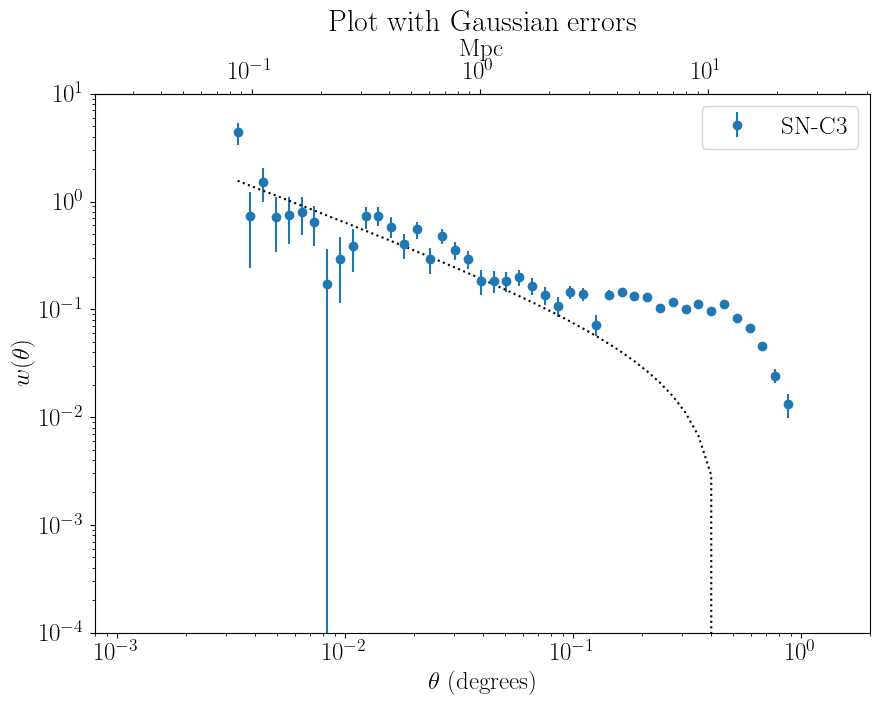

In [80]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.errorbar(X, w[:len(X)], yerr=Y_err, fmt='o', label='SN-C3')
ax.plot(X, w_t(A_median, power_median, X, mask_rr),'k:')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_title('Plot with Gaussian errors' )
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
ax.set_xlim([8e-4,2.])
secax = ax.secondary_xaxis('top',functions=(lambda x: x*Planck15.kpc_proper_per_arcmin(z_mean).value*60./1e3,
                                   lambda x: x*Planck15.arcsec_per_kpc_proper(z_mean).value*1e3/3.6e3))
secax.set_xlabel(r'Mpc')
ax.legend()
plt.savefig("clustering.png")
plt.show()


In [81]:
print(Y_err)
Y_err.shape

[1.00976658 0.49062812 0.53159516 0.3776816  0.3516985  0.30251073
 0.26172842 0.19539377 0.17826313 0.16719452 0.16789544 0.14730212
 0.12607579 0.10429841 0.09901882 0.07997584 0.07612723 0.06451281
 0.05604199 0.04745003 0.04216508 0.03738733 0.03344487 0.02925596
 0.02570245 0.02261263 0.02045335 0.01821622 0.01579082 0.01454339
 0.01282298 0.01121928 0.01009771 0.00898618 0.0081946  0.00735736
 0.00664204 0.00600921 0.00556215 0.00497244 0.00449346 0.00405009
 0.00367776 0.0034054  0.00323969]


(45,)

# Improving the estimates of the uncertainties. 
### Bootstrap Resampling for Covariance Matrix


The errors from a Gaussian approximation to Poisson errors are really an underestimate of the errors, and we really want the covariance matrix for our data - because the points are not independent of one another. The treecorr package has some better methods included, but we'll start by performing bootstrap resampling by hand.
The idea is that we draw a sample of N objects from our data set, where N is the size of your current sample. But whenever we draw a sample, it is still available to be drawn again a second or third time etc. - you'll see this referred to as drawing randomly with replacement.

In [82]:
N= len(catalog) #catalog of our subset of galaxies

print(N)

927


What np.arange does is construct an array, [0,1,2,3,...N] up to the number given as argument, in this case the size of our data set. Then, np.random.choice selects one the array values at random, and does this as many times as we ask with 'size='. So sample_indices will now contain a set of integers corresponding to index values of our data set.  

Our bootstrap sample is then
bs_galaxies = data[sample_indices]


We then want to recompute the DD and DR pair counts and w(theta) for this bootstrap sample (RR remains the same).
Do this 100 times, saving the w(theta) for each bootstrap sample. Then compute the variance per theta bin from those 100 samples.
We'll then go on to compute the covariance.

In [83]:
def count_pairs(catalog, random_catalog, theta_edges):
    
    separation = catalog.separation(random_catalog[:, np.newaxis]) #Calculates the angular separation between all pairs of objects in a catalog.
    pair_counts,_= np.histogram(np.log10(separation.value),bins=theta_edges)


    return pair_counts




In [84]:
bootstrap_samples = []
w_theta_bootstrap = []

theta_edges=np.linspace(-2.5,0.25,50) #-2.5 and 0.25 are log of the max 1.78 ° and min 0.03 ° separation 

# Loop over bootstrap samples
for i in range(100): #100 range
    
    # Generate random indices for the bootstrap sample
    sample_indices = np.random.choice(np.arange(N), size=N) 
    # Create the bootstrap sample
    bs_galaxies = catalog[sample_indices]

    # Compute DD, DR, and RR pair counts for the bootstrap sample
    dd_counts = count_pairs_in_theta_bin(bs_galaxies, theta_edges)    
    #rr_counts = count_pairs_in_theta_bin(random_catalog, theta_edges)
    dr_counts = count_pairs(bs_galaxies, random_catalog, theta_edges)

    
    #Normalise
    dd= dd_counts/np.sum(dd_counts) 
    rr= rr_counts/np.sum(rr_counts) 
    dr = dr_counts/ np.sum(dr_counts)

    # Compute w(theta) for the bootstrap sample
    w_theta = (dd -2* dr + rr)/ rr

    # Store the bootstrap sample and w(theta) values
    #bootstrap_samples.append(bs_galaxies)
    w_theta_bootstrap.append(w_theta)

# Compute variance per theta bin
variance = np.var(w_theta_bootstrap, axis=0)
#Calculate the covariance matrix
covariance = np.cov(w_theta_bootstrap)

/var/folders/sm/7ys1bjcx13x_c71jgspgdldh0000gn/T/ipykernel_10263/974065978.py:13: RuntimeWarning: divide by zero encountered in log10
  theta_hist,_= np.histogram(np.log10(separation.value),bins=theta_edges)


In [85]:
std_devs = np.sqrt(variance)

In [86]:
std_dev= np.std(w_theta_bootstrap, axis=0) #woks better with axis=0 than axis=1 (errors are very big in the latter case)
print(std_dev)
std_dev.shape

[2.01875119 1.20153334 1.06145594 0.97880097 0.82681658 0.73214144
 0.71400259 0.51040364 0.46890328 0.44207445 0.40901    0.36968743
 0.31122465 0.2630266  0.25265928 0.23850495 0.18510429 0.16466382
 0.13320237 0.13480232 0.11973427 0.09104419 0.09387577 0.08670071
 0.07055406 0.05883671 0.06636145 0.06204734 0.04396746 0.04535183
 0.03651651 0.03098385 0.027675   0.02840824 0.02126015 0.02402674
 0.02257601 0.02045438 0.0174526  0.01577132 0.01306789 0.01314778
 0.01240437 0.01083954 0.01062396 0.01181338 0.01107802 0.01499297
 0.01738206]


(49,)

In [53]:
Std = np.sqrt(np.diag(covariance))  # Standard errors
print(Std)
Std.shape

[0.76233555 0.78159531 0.35251448 0.64392812 0.65009154 0.98700807
 0.72825812 0.62585645 0.75164868 1.03813975 0.57120399 0.84384904
 0.46606423 1.07678587 0.38419409 0.37174912 0.731306   0.50328045
 0.62718308 1.20344436 0.69019524 0.57458197 0.65844255 1.67204956
 0.72458255 0.76374086 0.66090821 0.4455077  0.53359979 0.76894219
 0.9171415  1.37449579 0.87433451 0.84655925 0.47237818 0.42281343
 0.52933783 1.07176215 1.26190876 0.74831368 0.94052426 0.84402049
 0.76570109 0.53114219 0.42073982 1.27723462 0.42000426 0.76711243
 0.36603566 0.28028054 0.85514606 0.37173366 0.4449964  1.11882025
 0.81570257 1.02768682 0.40363181 0.39817468 0.52282657 0.65610665
 0.85574056 0.68771773 0.82135834 0.79010114 0.63364212 0.90145587
 0.59027051 0.58862666 0.48744921 0.77562979 0.83084502 0.63661513
 1.07577077 0.52341346 1.08743916 0.52604385 1.78086919 0.46986614
 0.84091726 0.87258893 0.69498704 0.45640478 1.1851616  0.99656616
 0.57753418 0.55411105 1.97996005 0.88350801 0.58803545 0.5884

(100,)

0.03231464976015835


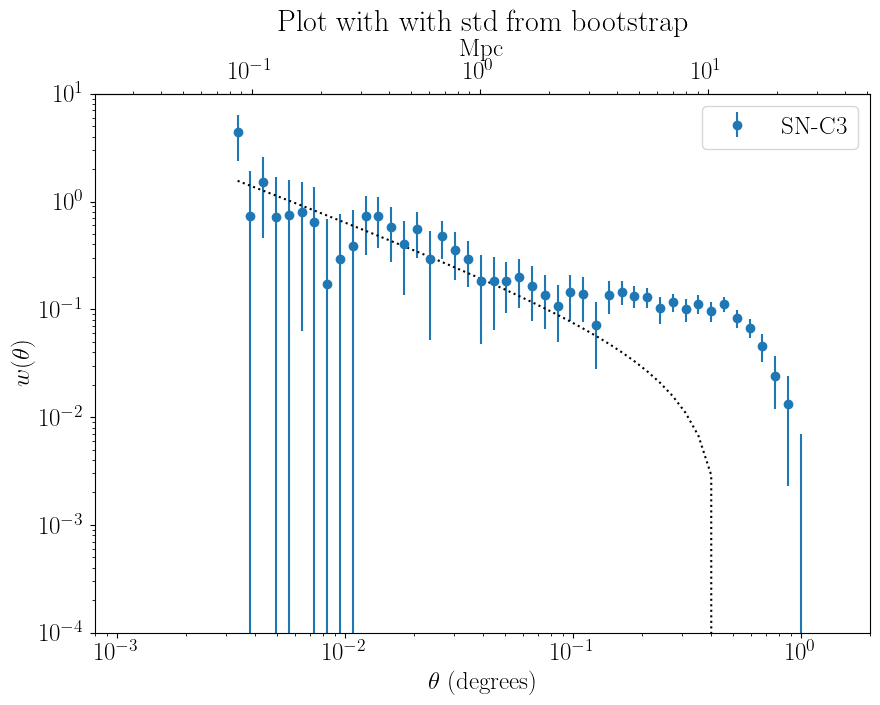

In [90]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.errorbar(X, w[:len(X)], yerr=std_dev[:len(X)], fmt='o', label='SN-C3')
ax.plot(X, w_t(A_median, power_median, X, mask_rr),'k:')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_title('Plot with with std from bootstrap' )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
ax.set_xlim([8e-4,2.])
secax = ax.secondary_xaxis('top',functions=(lambda x: x*Planck15.kpc_proper_per_arcmin(z_mean).value*60./1e3,
                                   lambda x: x*Planck15.arcsec_per_kpc_proper(z_mean).value*1e3/3.6e3))
secax.set_xlabel(r'Mpc')
ax.legend()
plt.savefig("clustering-by-hand.png")
plt.show()

# Switching from custom pair-counting function to the treecorr package.
## NNCorrelation: Count-count correlations

Bases: Corr2

This class handles the calculation and storage of a 2-point count-count correlation function. i.e. the regular density correlation function.

In [2]:
import astropy.io.fits as fits
import numpy as np
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.table import Table,join
import os
import matplotlib.pyplot as plt
from astropy.cosmology import FlatLambdaCDM
import treecorr



# Get the current user's home directory
home_dir = os.path.expanduser('~')

# Construct the path to the "Thesis" directory on the desktop
thesis_path = os.path.join(home_dir, 'Desktop', 'Thesis')


# Assuming you have the path to the FITS file stored in thesis_path
fits_file_path = os.path.join(thesis_path, "Y3_deep_fields_DB_wKNN_cat_SN-C3_zm.fits")  # Replace with your actual file name
fits_random = os.path.join(thesis_path, "SN-C3_randoms_ugriz_trim_video.fits") 
masked = os.path.join('/Volumes/data/SN-C3_masked_cat.fits')  


t= Table.read(fits_file_path)
t2= Table.read(fits_random)
t3= Table.read(masked)

In [3]:
t=join(t,t3,keys='id')


t.rename_column('ra_1','ra')
t.rename_column('dec_1','dec')

In [4]:
# Select redshift subset 
subset = (t['z'] > 0.6) & (t['z'] < 0.7) & (t['SM']>10.5)& (t['SM']<11) #solar masses

# Extract right ascension (ra) and declination (dec) arrays from the subset
ra_subset = t['ra'][subset] #[::100]
dec_subset = t['dec'][subset]#[::100]


ra_2 = t2['ra'][::1000]
dec_2 = t2['dec'][::1000]

## !!! careful: choose the catalog subset

In [5]:

config = {
    'ra_col': 'ra',
    'dec_col': 'dec',
    'ra_units': 'deg',
    'dec_units': 'deg',
    'min_sep': 0.003,  # Define the minimum separation
    'max_sep': 1.78,   # Define the maximum separation
    'bin_size': 0.1,# Define the desired bin size (adjust as needed),
    'sep_units':'deg'

}


#cat1 = treecorr.Catalog(fits_file_path, config, npatch = 50 ) 
#cat2 = treecorr.Catalog(fits_random, config, npatch = 50 ) 
ra=ra_subset*u.deg
dec=dec_subset*u.deg



ra_rand=ra_2*u.deg
dec_rand=dec_2*u.deg


cat1 = treecorr.Catalog(ra=ra, dec=dec, config=config, npatch=50)  # my catalog subset
#cat2 = treecorr.Catalog(ra= ra_rand, dec= dec_rand, config=config, npatch=50)
cat2 = treecorr.Catalog(fits_random, config=config, npatch=50)

In [6]:

#treecorr.NNCorrelation class requires two mandatory parameters: min_sep and max_sep.
#These parameters define the minimum and maximum separation distances considered when calculating the correlation function.

dd = treecorr.NNCorrelation(config) #var_method='bootstrap'
rr = treecorr.NNCorrelation(config)


## kernel always dies here and my notebook also sometimes randomly deletes itself :((

In [7]:
dd.process(cat1)   
rr.process(cat2)  

In [8]:
rd = treecorr.NNCorrelation(config) 
dr = treecorr.NNCorrelation(config)

In [9]:
rd.process(cat1, cat2)   
dr.process(cat1, cat2)  

## *!*  *Question is it correct to only to the correletion function for dd? in the sense is it correct to only write dd.calculateXi(rr=rr, dr=dr) ?*

In [88]:

#dd.write(catalog,rr=rr,dr=dr,rd=rd)# Write out to a file.

#dd.calculatexi(dr=dr, rr=rr)

dd.calculateXi(rr=rr, dr=dr)

AttributeError: 'numpy.ndarray' object has no attribute 'calculateXi'

In [11]:
dd_cov = dd.cov  # Can access covariance now.

In [12]:
dd_cov_bs = dd.estimate_cov(method='bootstrap') 

If calculateXi has been called, then the following will also be available:

* xi – The correlation function, 
* varxi – An estimate of the variance of 
* cov – An estimate of the full covariance matrix.

In [19]:
diag = dd.estimate_cov(method='shot') #  In this case, the returned value will only be the diagonal.
err= np.sqrt(diag)


dd.estimate_cov gives you a 2-D array, but the off-diagonal values are all 0 in the case of the shot-noise only covariance. When you use np.sqrt(), it operates element-wise, so your err array is still 2-D.

When you plot it, I guess it's using only the first line, which has one value to being with and then zeros afterwards.
Because all non-diagonal values are zero, you can sum over the axis:

ax.errorbar(X, w[:len(X)], yerr=np.sum(err, axis=1)[:len(X)], fmt='o', label='SN-C3 with std using tree corr')

For the bootstrap you can't do that, so you could use list comprehension (though there's probably a much smarter way to do it using an idenity matrix....)

err = np.array([dd_cov_bs[i,i] for i in range(len(X))])



In [60]:
err.shape


(64,)

In [67]:
error=np.sum(err)
print(error)


8.291872209164199


0.03231464976015835


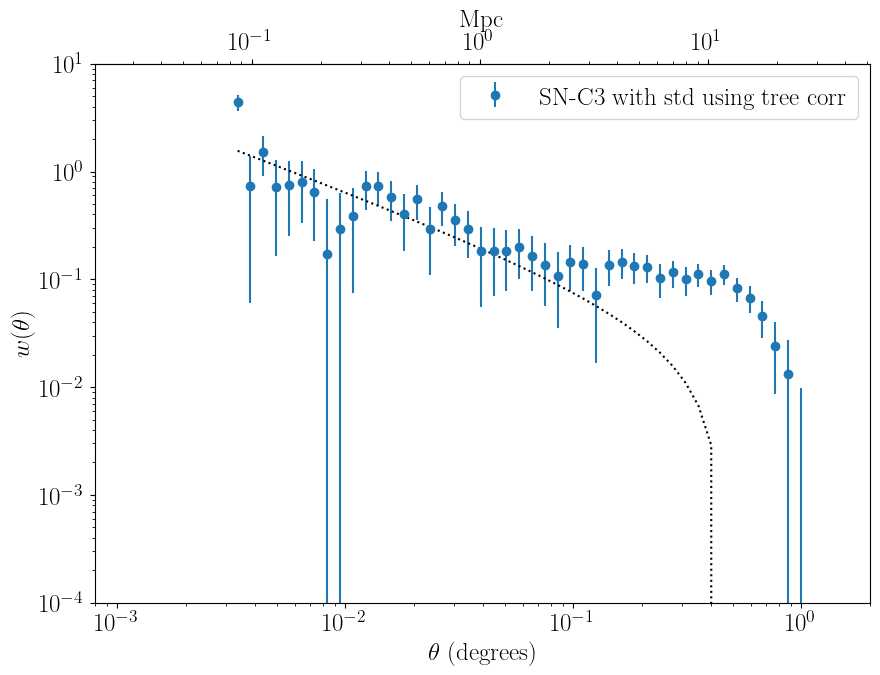

In [89]:
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(111)
ax.errorbar(X, w[:len(X)], yerr=err[:len(X)], fmt='o', label='SN-C3')
ax.plot(X, w_t(A_median, power_median, X, mask_rr),'k:')
ax.set_xlabel(r'$\theta$ (degrees)')
ax.set_ylabel(r'$w(\theta)$')
ax.set_title('Plot with with std using tree corr' )

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1e-4,10.])
ax.set_xlim([8e-4,2.])
secax = ax.secondary_xaxis('top',functions=(lambda x: x*Planck15.kpc_proper_per_arcmin(z_mean).value*60./1e3,
                                   lambda x: x*Planck15.arcsec_per_kpc_proper(z_mean).value*1e3/3.6e3))
secax.set_xlabel(r'Mpc')
ax.legend()
plt.savefig("clustering-with-treecorr.png")
plt.show()

# Accounting for the projection in the angular correlation function to infer a 3D physical quantity, r0 (in Mpc).


### The angular correlation function (w(theta)) measures the clustering of galaxies on the sky. However, it's a 2D projection of the underlying 3D distribution. To infer the 3D physical quantity r0 (comoving correlation length), we need to deproject w(theta)

## Convert units

In [ ]:
import astropy.units as u
from astropy.cosmology import FlatLambdaCDM

cosmo = FlatLambdaCDM(H0=67.8, Om0=0.308)  

# Calculate angular diameter distance (d_A)
d_A = cosmo.angular_diameter_distance(z=0.65)  # Average redshift 


# Convert theta from radians to Mpc
theta_Mpc = d_A * deg_theta_cen

# Convert theta_Mpc to h^-1 Mpc
theta_h_inv_Mpc =  theta_Mpc / (cosmo.H0 * u.km / u.s / u.Mpc)


In [ ]:

fit_mpc = theta_h_inv_Mpc ** (-0.8)
plt.yscale('log')
plt.plot(theta_h_inv_Mpc, fit_mpc, label='Power Law Fit')
plt.scatter(theta_h_inv_Mpc, two_pcf_result)

# Set labels and title
plt.xlabel(r'$ \theta(h^{-1} Mpc)$')
plt.ylabel( r'$w(\theta)$')
plt.yscale('log')
plt.title("Power Law ")
plt.grid(True)
plt.show()

fit power law and slope of -0.8
integral constraint, check in papers